# Filtering Music

In this notebook we will design and use filters to extract specific audio information from a piece of music.

In [1]:
%pylab inline

from sympy import *
init_printing(use_unicode = True, fontsize = 16)

pi2 = pi * 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys 

if os.name == 'nt':
    path = 'C:\\Users\\Wei\\Dropbox\\Coding\\notebooks\\專案\\待處理\\Waves\\bitbucket\\github\\codes'
else:
    path = '/home/wei/Dropbox/Coding/notebooks/專案/待處理/Waves/bitbucket/github/codes'
    
sys.path.append(path)

from waves.sound import *
from waves.tools.dsp import *

In [3]:
import IPython
import scipy.signal as sp
from scipy.io import wavfile

Let's load a short audio clip (hoping we won't be sued for copyright infringment...)

In [4]:
SF, s = wavfile.read('sm.wav')
IPython.display.Audio(s, rate=SF)

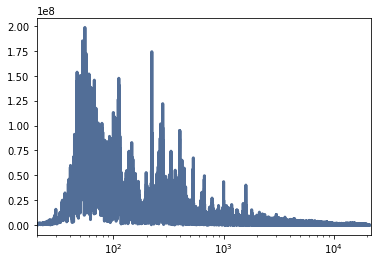

In [5]:
Channel(s, framerate=SF).make_spectrum().plot()

Suppose I'm interested in the bass part; I know the bass will have most of its energy in the low frequency range. I could try to filter the audio with a lowpass with cutoff, say, 200Hz and see what comes out of it (you will need headphones to hear properly).

Remember that the clock of the system is given by the sampling rate of the audio clip, so we will need to normalize the frequencies by  SF/2 so that the highest frequency corresponds to 1.

Let's start with a Butterworth filter:

In [6]:
fc = 200.0
freq_niq = SF/2
wc = fc / freq_niq
b, a = sp.butter(6, wc)

In [7]:
wb, Hb = sp.freqz(b, a, worN = 1024)

No handles with labels found to put in legend.


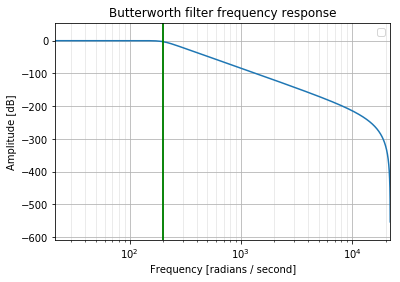

In [8]:
Filter.plot_freq_response(wb/np.pi * freq_niq, Hb, wc = [fc])
plt.title('Butterworth filter frequency response');

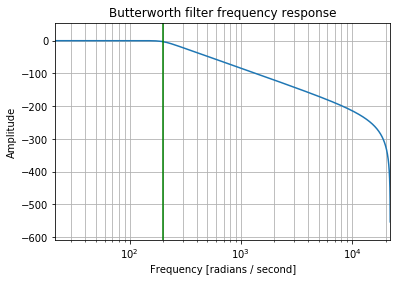

In [9]:
# plt.plot(wb/np.pi*freq_niq, (np.abs(Hb)))
plt.plot(wb/np.pi*freq_niq, 20 * np.log10(abs(Hb)))

plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude')# [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(fc, color='green') # cutoff frequency
plt.show()

In [10]:
# let's filter the signal and hear the result
y = sp.lfilter(b, a, s)
IPython.display.Audio(data = y, rate = SF)

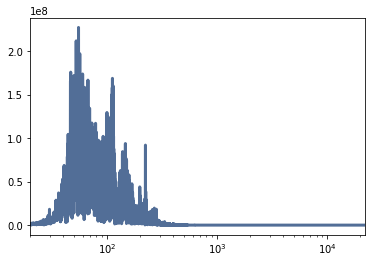

In [11]:
Channel(y, framerate=SF).make_spectrum().plot()

### Impulse response of the filter

C:\Softwares\Python\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


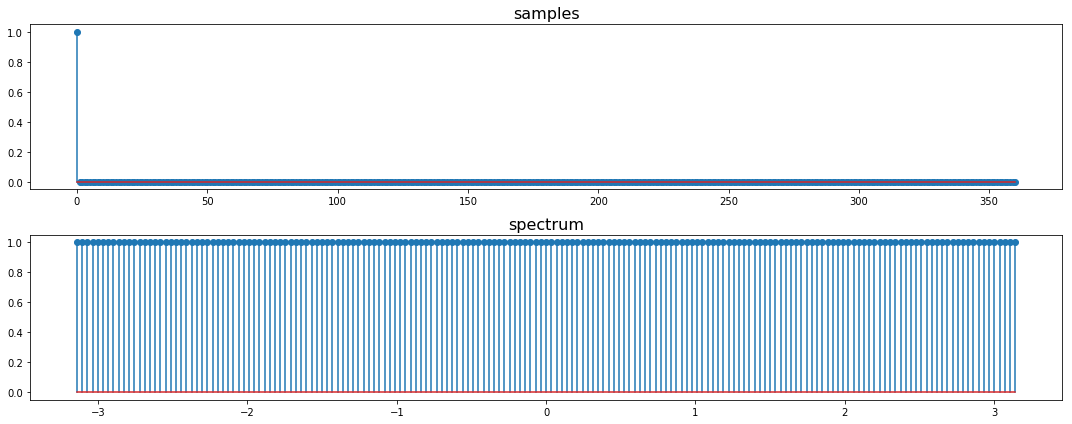

In [12]:
# n = np.arange(N_SAMPLES)
n = np.arange(N_SAMPLES*2+1)
# n = np.arange(1200)
x = DSP.delta(n)
X2 = Fourier.dtft(x, plt_abs = False)

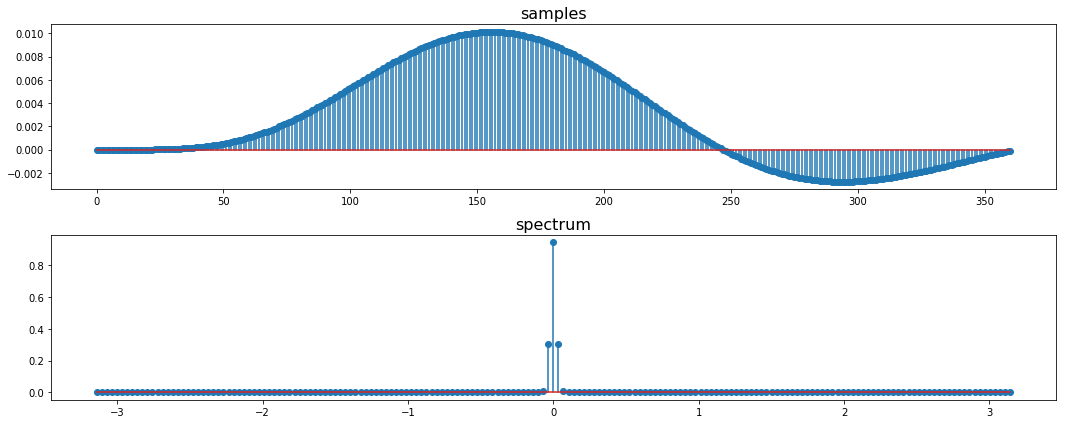

In [13]:
h2 = sp.lfilter(b, a, x)
H2 = Fourier.dtft(h2, plt_abs = False)

In [14]:
len(h2)

### 由 analog filter 的 impulse response 當作 FIR filter

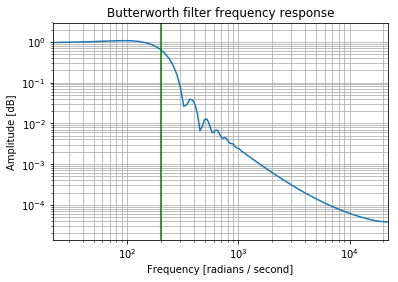

In [15]:
w2, H2 = sp.freqz(h2, 1, 1024)
plt.semilogy(w2/np.pi * (SF/2), np.abs(H2))

plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(fc, color='green') # cutoff frequency
plt.show()

In [16]:
y = sp.lfilter(h2, 1, s)
IPython.display.Audio(y, rate=SF)

C:\Softwares\Python\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


Well, it's certainly not a perfect source separation but, if you're trying to learn the bass part, this would be a good start.

We can try to achieve the same effect using FIR filters, and you'll see it's possible but we will need a lot of taps since the bandwidth is small. We can use the built-in normalization facility of Scipy's remez() function:

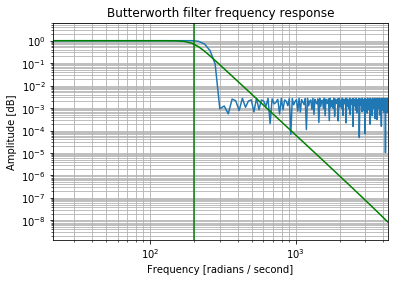

In [17]:
# transition band:
tb = 100

# length of the filter
M = 1200
h = sp.remez(numtaps = M,
             bands = [0, fc, fc+tb, SF/2], 
             desired = [1, 0], 
             weight = [1, 1], 
             Hz = SF, 
             maxiter = 50)

w, H = sp.freqz(h, 1, 1024)

plt.semilogy(w[0:200]/np.pi * freq_niq, np.abs(H[0:200]))
plt.plot(wb[0:200]/np.pi * freq_niq, np.abs(Hb[0:200]), 'green');

plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(fc, color='green') # cutoff frequency
plt.show()

As you can see, the FIR filter will be very expensive! Is it worth it? Well, you can judge for yourself: arguably linear phase preserves the instrumental attack more, but the high frequency rejection is not as good.

In [18]:
y = sp.lfilter(h, 1, s)
IPython.display.Audio(y, rate=SF)

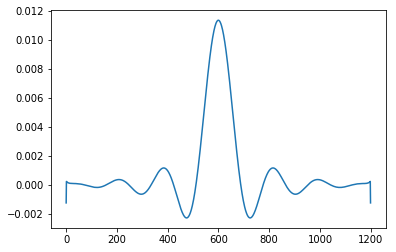

In [19]:
plt.plot(h);

Just like we tried to extract the bass, we can try to extract parts of the drum patterd. Usually, we get a good feel for the hi-hat and cymbals by keeping frequencies above 7KHz.

Let's use an FIR highpass; note that, to design a highpass, we choose a type II filter, so the length will be odd

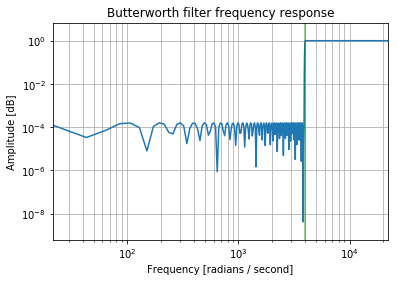

In [20]:
fh = 4000; 
M = 1601;
hh = sp.remez(M, [0, fh - tb, fh, SF/2], [0, 1], [10, 1], Hz=SF, maxiter=50)

w, HH = sp.freqz(hh, 1, 1024)
plt.semilogy(w/np.pi * (SF/2), np.abs(HH))

plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(fh, color='green', alpha = 0.5) # cutoff frequency
plt.show()

In [21]:
y = sp.lfilter(hh, 1, s)
IPython.display.Audio(y, rate=SF)

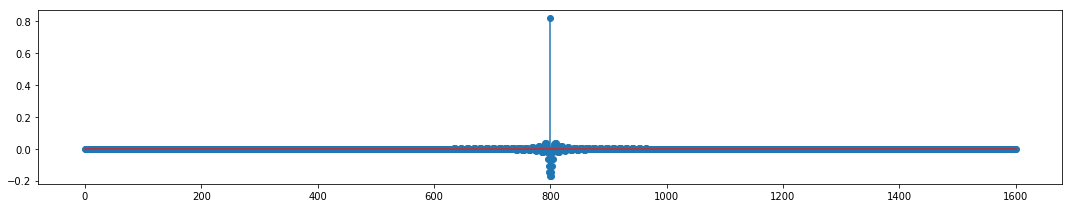

In [22]:
DSP.plot_comparison([hh])